In [99]:
import numpy as np
import pandas as pd

import keras.backend as K
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import shap

import cv2

# Helper Functions

In [2]:
# plot predicted probabilites
def plot_prob(y_hat, inv_class_map, top_n=5):
    top_n_idx = (-y_hat).argsort()[:top_n]
    labels = [inv_class_map[k] for k in top_n_idx]
    
    d = pd.DataFrame({'label': labels, 
                      'prob': y_hat[top_n_idx]})
    sns.barplot(x='prob', y='label', data=d, color='y')
    plt.show()

In [3]:
def get_acc(true, pred):
    cm = confusion_matrix(true, pred) 
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    return cm.diagonal()

In [4]:
# plot training and validation accuracy
def plot_acc(file_path):
    history_log = pd.read_csv(file_path)

    history_log['epoch'] += 1
    history_log = history_log.drop(['loss', 'val_loss'], axis=1)
    history_log = pd.melt(history_log, id_vars=['epoch'], value_vars=['acc', 'val_acc'])

    sns.set()
    plt.figure(figsize=(7, 7))
    ax = sns.lineplot(x='epoch', y='value', hue='variable', data=history_log, legend='full')
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel('Accuracy', fontsize=12)

    plt.title('Accuracy in Each Epoch')
    plt.legend(title='', loc='lower right', labels=['Training', 'Validation'])
    
    model_id = file_path.split('/')[2].split('.')[0]
    plt.savefig('../data/output/acc_' + model_id + '.png')
    plt.show()

In [5]:
def rgb_to_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

# Load test dataset

In [7]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNELS = 3

test_dir = '../data/input/classification/Test/'

In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=1,
        shuffle=False)

Found 16421 images belonging to 95 classes.


In [9]:
y_test = test_generator.classes

In [10]:
n_y_test = len(y_test)

In [19]:
inv_class_map = {v: k for k, v in test_generator.class_indices.items()}

# Model 1 (Batch normalization + ReLU)

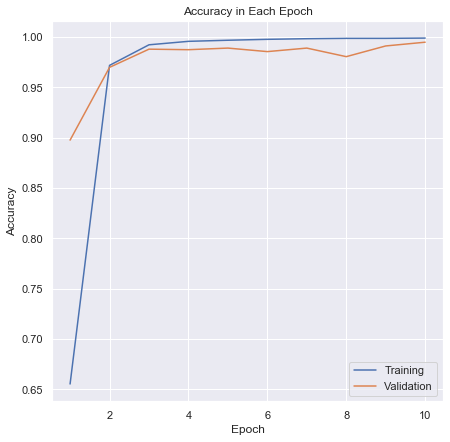

In [12]:
plot_acc('../log/model_1.log')

In [11]:
model_1 = load_model('../model/model_1.h5')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [12]:
test_generator.reset()
y_hat_1 = model_1.predict_generator(test_generator, steps=n_y_test)
y_pred_1 = np.argmax(y_hat_1, axis=1)

print(classification_report(y_test, y_pred_1, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       164
           1     0.8579    0.9939    0.9209       164
           2     1.0000    1.0000    1.0000       164
           3     1.0000    1.0000    1.0000       161
           4     1.0000    1.0000    1.0000       164
           5     1.0000    1.0000    1.0000       164
           6     1.0000    1.0000    1.0000       164
           7     1.0000    1.0000    1.0000       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    0.8354    0.9103       164
          10     1.0000    1.0000    1.0000       219
          11     1.0000    1.0000    1.0000       164
          12     1.0000    1.0000    1.0000       143
          13     1.0000    1.0000    1.0000       166
          14     0.9708    1.0000    0.9852       166
          15     1.0000    1.0000    1.0000       152
          16     0.9540    1.0000    0.9765       166
          17     1.0000    

In [13]:
accuracy_1 = get_acc(y_test, y_pred_1)

# Model 2 (HSV transformation + Batch normalization + ReLU)

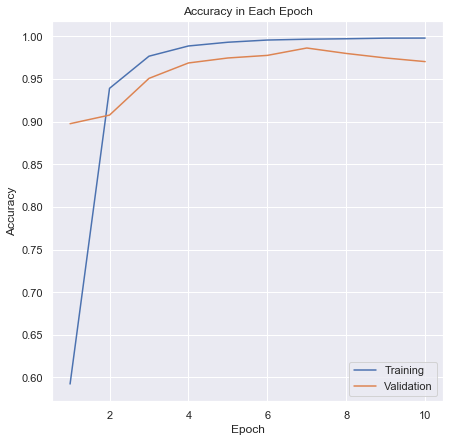

In [18]:
plot_acc('../log/model_2.log')

In [19]:
model_2 = load_model('../model/model_2.h5')

In [37]:
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=rgb_to_hsv)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=1,
        shuffle=False)

Found 16421 images belonging to 95 classes.


In [38]:
y_hat_2 = model_2.predict_generator(test_generator, steps=n_y_test)
y_pred_2 = np.argmax(y_hat_2, axis=1)

print(classification_report(y_test, y_pred_2, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.6159    0.7623       164
           1     1.0000    0.9512    0.9750       164
           2     0.9939    1.0000    0.9970       164
           3     0.9253    1.0000    0.9612       161
           4     1.0000    0.9451    0.9718       164
           5     0.8896    0.8841    0.8869       164
           6     0.8723    1.0000    0.9318       164
           7     1.0000    0.9167    0.9565       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    0.6463    0.7852       164
          10     1.0000    1.0000    1.0000       219
          11     0.8159    1.0000    0.8986       164
          12     1.0000    1.0000    1.0000       143
          13     0.9822    1.0000    0.9910       166
          14     1.0000    0.7590    0.8630       166
          15     0.9618    0.9934    0.9773       152
          16     0.9935    0.9157    0.9530       166
          17     0.8300    

In [39]:
accuracy_2 = get_acc(y_test, y_pred_2)

#  Model 3 (ReLU + Batch normalization)

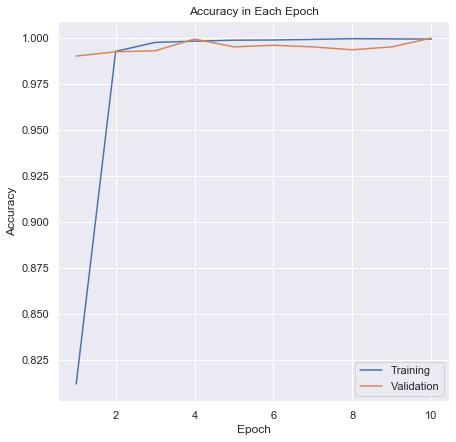

In [24]:
plot_acc('../log/model_3.log')

In [22]:
model_3 = load_model('../model/model_3.h5')

In [23]:
test_generator.reset()
y_hat_3 = model_3.predict_generator(test_generator, steps=n_y_test)
y_pred_3 = np.argmax(y_hat_3, axis=1)

print(classification_report(y_test, y_pred_3, digits=4))

              precision    recall  f1-score   support

           0     0.9737    0.9024    0.9367       164
           1     0.9819    0.9939    0.9879       164
           2     1.0000    1.0000    1.0000       164
           3     0.8429    1.0000    0.9148       161
           4     1.0000    0.9756    0.9877       164
           5     1.0000    0.9085    0.9521       164
           6     0.9939    1.0000    0.9970       164
           7     1.0000    0.9444    0.9714       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    0.9817    0.9908       164
          10     1.0000    1.0000    1.0000       219
          11     1.0000    1.0000    1.0000       164
          12     1.0000    1.0000    1.0000       143
          13     1.0000    1.0000    1.0000       166
          14     1.0000    1.0000    1.0000       166
          15     0.9935    1.0000    0.9967       152
          16     0.9940    1.0000    0.9970       166
          17     1.0000    

In [24]:
accuracy_3 = get_acc(y_test, y_pred_3)

# Model 4 (ReLU + Dropout)

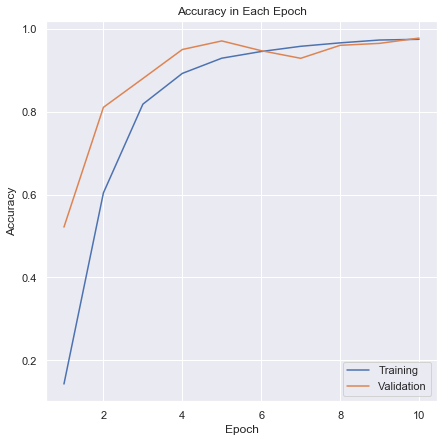

In [65]:
plot_acc('../log/model_4.log')

In [43]:
model_4 = load_model('../model/model_4.h5')

test_generator.reset()
y_hat_4 = model_4.predict_generator(test_generator, steps=n_y_test)
y_pred_4 = np.argmax(y_hat_4, axis=1)

print(classification_report(y_test, y_pred_4, digits=4))

              precision    recall  f1-score   support

           0     0.7703    0.6951    0.7308       164
           1     0.7919    0.9512    0.8643       164
           2     0.8367    1.0000    0.9111       164
           3     1.0000    1.0000    1.0000       161
           4     1.0000    1.0000    1.0000       164
           5     0.9704    1.0000    0.9850       164
           6     0.9536    0.8780    0.9143       164
           7     0.9931    1.0000    0.9965       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    0.6402    0.7807       164
          10     1.0000    1.0000    1.0000       219
          11     1.0000    1.0000    1.0000       164
          12     1.0000    1.0000    1.0000       143
          13     0.9071    1.0000    0.9513       166
          14     0.9274    1.0000    0.9623       166
          15     1.0000    0.8158    0.8986       152
          16     1.0000    0.8614    0.9256       166
          17     0.9940    

In [44]:
accuracy_4 = get_acc(y_test, y_pred_4)

# Model 5 (HSV transformation + ReLU + Batch normalization)

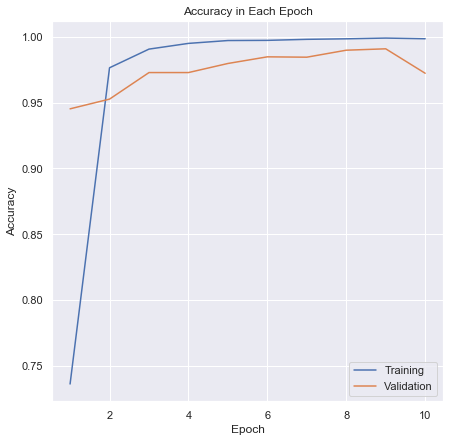

In [66]:
plot_acc('../log/model_5.log')

In [56]:
model_5 = load_model('../model/model_5.h5')

In [57]:
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=rgb_to_hsv)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
        batch_size=1,
        shuffle=False)

Found 16421 images belonging to 95 classes.


In [58]:
y_hat_5 = model_5.predict_generator(test_generator, steps=n_y_test)
y_pred_5 = np.argmax(y_hat_5, axis=1)

print(classification_report(y_test, y_pred_5, digits=4))

              precision    recall  f1-score   support

           0     0.9444    0.7256    0.8207       164
           1     1.0000    0.8476    0.9175       164
           2     0.8723    1.0000    0.9318       164
           3     1.0000    0.9503    0.9745       161
           4     0.9535    1.0000    0.9762       164
           5     0.8708    0.9451    0.9064       164
           6     0.8542    1.0000    0.9213       164
           7     0.8882    0.9931    0.9377       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    0.6585    0.7941       164
          10     1.0000    1.0000    1.0000       219
          11     1.0000    0.9939    0.9969       164
          12     1.0000    1.0000    1.0000       143
          13     1.0000    1.0000    1.0000       166
          14     1.0000    0.8313    0.9079       166
          15     1.0000    0.9671    0.9833       152
          16     0.9448    0.9277    0.9362       166
          17     0.8469    

In [59]:
accuracy_5 = get_acc(y_test, y_pred_5)

# Model 6 (Batch normalization + ReLU + learning rate scheduler)

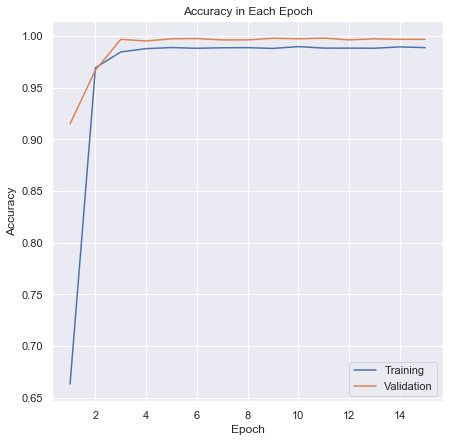

In [67]:
plot_acc('../log/model_6.log')

In [46]:
model_6 = load_model('../model/model_6.h5')

test_generator.reset()
y_hat_6 = model_6.predict_generator(test_generator, steps=n_y_test)
y_pred_6 = np.argmax(y_hat_6, axis=1)

print(classification_report(y_test, y_pred_6, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.6646    0.7985       164
           1     0.9819    0.9939    0.9879       164
           2     1.0000    1.0000    1.0000       164
           3     0.9930    0.8758    0.9307       161
           4     0.8913    1.0000    0.9425       164
           5     1.0000    1.0000    1.0000       164
           6     0.7810    1.0000    0.8770       164
           7     1.0000    0.8889    0.9412       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    0.9756    0.9877       164
          10     1.0000    1.0000    1.0000       219
          11     1.0000    1.0000    1.0000       164
          12     1.0000    1.0000    1.0000       143
          13     1.0000    1.0000    1.0000       166
          14     0.9379    1.0000    0.9679       166
          15     0.9935    1.0000    0.9967       152
          16     1.0000    0.8072    0.8933       166
          17     1.0000    

In [47]:
accuracy_6 = get_acc(y_test, y_pred_6)

# Model 7 (Batch normalization + LReLU (0.1))

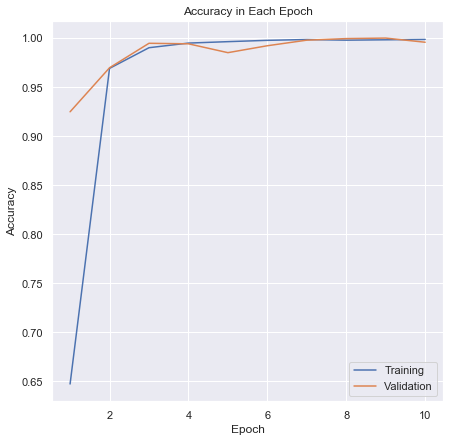

In [68]:
plot_acc('../log/model_7.log')

In [48]:
model_7 = load_model('../model/model_7.h5')

test_generator.reset()
y_hat_7 = model_7.predict_generator(test_generator, steps=n_y_test)
y_pred_7 = np.argmax(y_hat_7, axis=1)

print(classification_report(y_test, y_pred_7, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.9817    0.9908       164
           1     0.9939    0.9939    0.9939       164
           2     0.9939    1.0000    0.9970       164
           3     0.8564    1.0000    0.9226       161
           4     0.9880    1.0000    0.9939       164
           5     1.0000    1.0000    1.0000       164
           6     1.0000    1.0000    1.0000       164
           7     1.0000    1.0000    1.0000       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    0.9817    0.9908       164
          10     1.0000    1.0000    1.0000       219
          11     1.0000    1.0000    1.0000       164
          12     1.0000    1.0000    1.0000       143
          13     1.0000    1.0000    1.0000       166
          14     0.9940    1.0000    0.9970       166
          15     1.0000    1.0000    1.0000       152
          16     0.9632    0.9458    0.9544       166
          17     0.9881    

In [49]:
accuracy_7 = get_acc(y_test, y_pred_7)

# Model 8 (Batch normalization + LReLU (0.3))

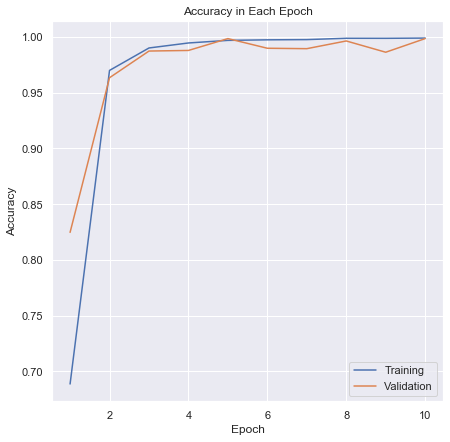

In [69]:
plot_acc('../log/model_8.log')

In [50]:
model_8 = load_model('../model/model_8.h5')

test_generator.reset()
y_hat_8 = model_8.predict_generator(test_generator, steps=n_y_test)
y_pred_8 = np.argmax(y_hat_8, axis=1)

print(classification_report(y_test, y_pred_8, digits=4))

              precision    recall  f1-score   support

           0     1.0000    0.7988    0.8881       164
           1     1.0000    0.9939    0.9969       164
           2     1.0000    1.0000    1.0000       164
           3     0.8474    1.0000    0.9174       161
           4     1.0000    1.0000    1.0000       164
           5     1.0000    1.0000    1.0000       164
           6     1.0000    1.0000    1.0000       164
           7     1.0000    1.0000    1.0000       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    0.9024    0.9487       164
          10     1.0000    1.0000    1.0000       219
          11     1.0000    1.0000    1.0000       164
          12     0.9931    1.0000    0.9965       143
          13     1.0000    1.0000    1.0000       166
          14     1.0000    1.0000    1.0000       166
          15     1.0000    1.0000    1.0000       152
          16     0.9540    1.0000    0.9765       166
          17     1.0000    

In [51]:
accuracy_8 = get_acc(y_test, y_pred_8)

# Model 9 (LRelu (0.3) + Batch normalization)

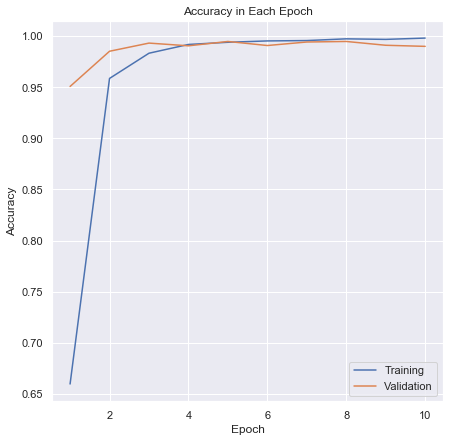

In [70]:
plot_acc('../log/model_9.log')

In [52]:
model_9 = load_model('../model/model_9.h5')

test_generator.reset()
y_hat_9 = model_9.predict_generator(test_generator, steps=n_y_test)
y_pred_9 = np.argmax(y_hat_9, axis=1)

print(classification_report(y_test, y_pred_9, digits=4))

              precision    recall  f1-score   support

           0     0.9360    0.9817    0.9583       164
           1     0.9879    0.9939    0.9909       164
           2     1.0000    1.0000    1.0000       164
           3     0.8131    1.0000    0.8969       161
           4     1.0000    1.0000    1.0000       164
           5     1.0000    0.7866    0.8805       164
           6     0.9820    1.0000    0.9909       164
           7     1.0000    1.0000    1.0000       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    1.0000    1.0000       164
          10     1.0000    1.0000    1.0000       219
          11     1.0000    1.0000    1.0000       164
          12     1.0000    1.0000    1.0000       143
          13     1.0000    1.0000    1.0000       166
          14     1.0000    1.0000    1.0000       166
          15     1.0000    1.0000    1.0000       152
          16     1.0000    0.9157    0.9560       166
          17     1.0000    

In [53]:
accuracy_9 = get_acc(y_test, y_pred_9)

# Model 10 (LRelu (0.5) + learning rate scheduler)

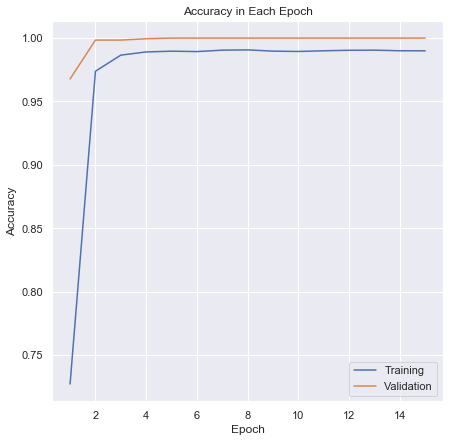

In [71]:
plot_acc('../log/model_10.log')

In [54]:
model_10 = load_model('../model/model_10.h5')

test_generator.reset()
y_hat_10 = model_10.predict_generator(test_generator, steps=n_y_test)
y_pred_10 = np.argmax(y_hat_10, axis=1)

print(classification_report(y_test, y_pred_10, digits=4))

              precision    recall  f1-score   support

           0     0.8041    0.9512    0.8715       164
           1     0.9477    0.9939    0.9702       164
           2     0.9318    1.0000    0.9647       164
           3     0.8610    1.0000    0.9253       161
           4     1.0000    1.0000    1.0000       164
           5     0.8599    0.8232    0.8411       164
           6     1.0000    1.0000    1.0000       164
           7     1.0000    1.0000    1.0000       144
           8     1.0000    1.0000    1.0000       166
           9     1.0000    1.0000    1.0000       164
          10     1.0000    1.0000    1.0000       219
          11     1.0000    1.0000    1.0000       164
          12     1.0000    1.0000    1.0000       143
          13     1.0000    1.0000    1.0000       166
          14     1.0000    1.0000    1.0000       166
          15     1.0000    0.8947    0.9444       152
          16     0.9563    0.9217    0.9387       166
          17     0.9071    

In [55]:
accuracy_10 = get_acc(y_test, y_pred_10)

# Summary of predictions

In [60]:
accuracy_df = pd.DataFrame({'class': np.arange(1, 96), 
                           'model_1': accuracy_1,
                           'model_2': accuracy_2,
                           'model_3': accuracy_3,
                           'model_4': accuracy_4,
                           'model_5': accuracy_5,
                           'model_6': accuracy_6,
                           'model_7': accuracy_7,
                           'model_8': accuracy_8,
                           'model_9': accuracy_9,
                           'model_10': accuracy_10,})

accuracy_df = pd.melt(accuracy_df, id_vars=['class'], 
                      value_vars=['model_1', 'model_2', 'model_3', 'model_4', 'model_5',
                                 'model_6', 'model_7', 'model_8', 'model_9', 'model_10'])

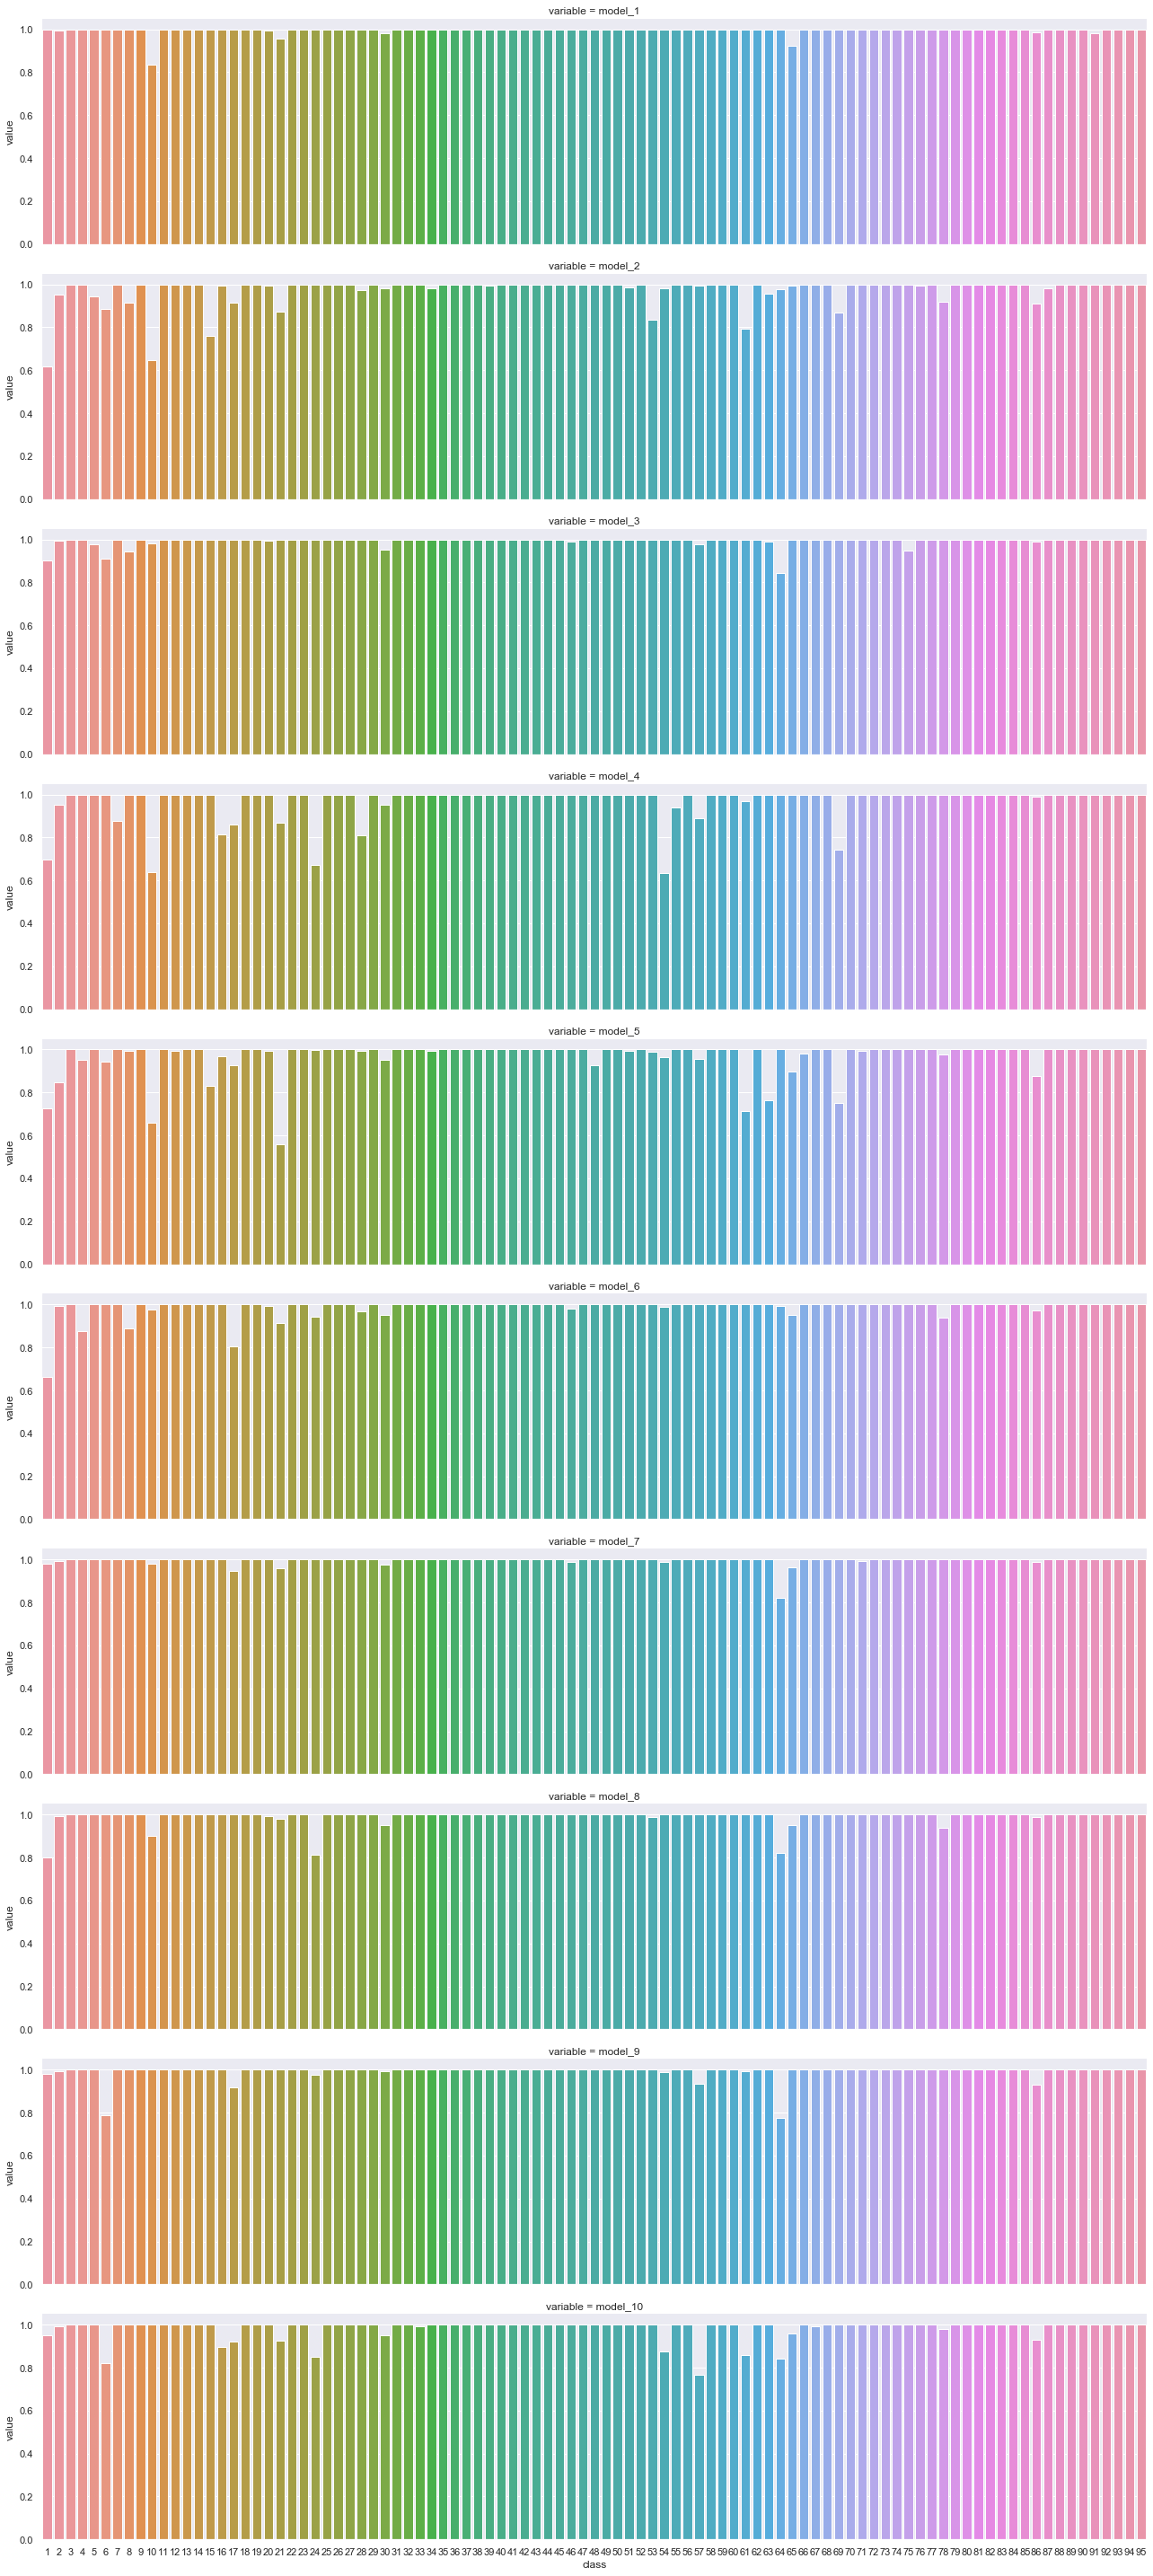

In [62]:
g = sns.catplot(x='class', y='value',
                row='variable', data=accuracy_df, 
                kind='bar', height=4, aspect=4.5)

In [64]:
g.savefig('../data/output/acc_summary.png')

# Investigation of the Predictions

In [37]:
np.argmin(accuracy_1)

9

In [21]:
# class with the lowest accuracy
inv_class_map[np.argmin(accuracy_1)]

'Apple Red Yellow 1'

In [35]:
np.where(y_test == 9)

(array([1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465,
        1466, 1467, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476,
        1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487,
        1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498,
        1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509,
        1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520,
        1521, 1522, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531,
        1532, 1533, 1534, 1535, 1536, 1537, 1538, 1539, 1540, 1541, 1542,
        1543, 1544, 1545, 1546, 1547, 1548, 1549, 1550, 1551, 1552, 1553,
        1554, 1555, 1556, 1557, 1558, 1559, 1560, 1561, 1562, 1563, 1564,
        1565, 1566, 1567, 1568, 1569, 1570, 1571, 1572, 1573, 1574, 1575,
        1576, 1577, 1578, 1579, 1580, 1581, 1582, 1583, 1584, 1585, 1586,
        1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597,
        1598, 1599, 1600, 1601, 1602, 

In [58]:
test_generator.filenames[1508]

'Apple Red Yellow 1/74_100.jpg'

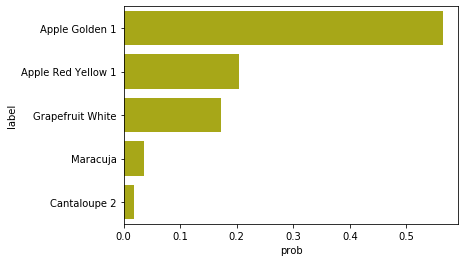

In [57]:
plot_prob(y_hat_1[1508], inv_class_map, 5)

In [66]:
test_generator.filenames[1535]

'Apple Red Yellow 1/99_100.jpg'

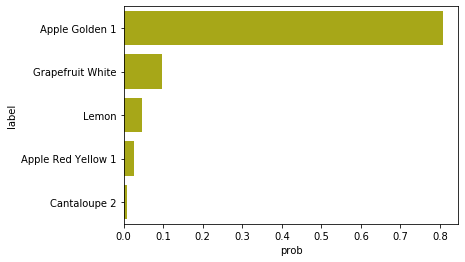

In [68]:
plot_prob(y_hat_1[1535], inv_class_map, 5)

In [72]:
test_generator.filenames[1468]

'Apple Red Yellow 1/38_100.jpg'

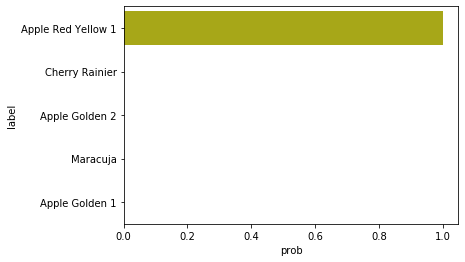

In [73]:
plot_prob(y_hat_1[1468], inv_class_map, 5)

In [89]:
# class with the second lowest accuracy
inv_class_map[64]

'Pear Abate'

In [91]:
np.where(y_test == 64)

(array([10937, 10938, 10939, 10940, 10941, 10942, 10943, 10944, 10945,
        10946, 10947, 10948, 10949, 10950, 10951, 10952, 10953, 10954,
        10955, 10956, 10957, 10958, 10959, 10960, 10961, 10962, 10963,
        10964, 10965, 10966, 10967, 10968, 10969, 10970, 10971, 10972,
        10973, 10974, 10975, 10976, 10977, 10978, 10979, 10980, 10981,
        10982, 10983, 10984, 10985, 10986, 10987, 10988, 10989, 10990,
        10991, 10992, 10993, 10994, 10995, 10996, 10997, 10998, 10999,
        11000, 11001, 11002, 11003, 11004, 11005, 11006, 11007, 11008,
        11009, 11010, 11011, 11012, 11013, 11014, 11015, 11016, 11017,
        11018, 11019, 11020, 11021, 11022, 11023, 11024, 11025, 11026,
        11027, 11028, 11029, 11030, 11031, 11032, 11033, 11034, 11035,
        11036, 11037, 11038, 11039, 11040, 11041, 11042, 11043, 11044,
        11045, 11046, 11047, 11048, 11049, 11050, 11051, 11052, 11053,
        11054, 11055, 11056, 11057, 11058, 11059, 11060, 11061, 11062,
      

In [97]:
test_generator.filenames[11094]

'Pear Abate/r_91_100.jpg'

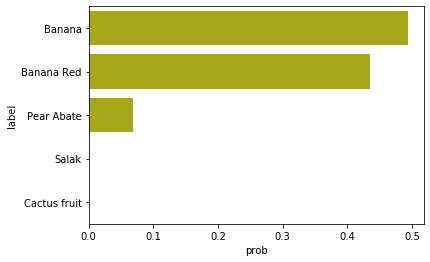

In [98]:
plot_prob(y_hat_1[11094], inv_class_map, 5)

# SHAP

In [182]:
def map2layer(x, model, layer):
    feed_dict = dict(zip([model.layers[0].input], [x]))
    return K.get_session().run(model.layers[layer].input, feed_dict)

def displot_shap(X, index, model, layer, inv_class_map):
    to_explain = X[[index]]
    
    shap_values, indexes = e.shap_values(map2layer(to_explain, model, layer), ranked_outputs=2)
    index_names = np.vectorize(lambda x: inv_class_map[x])(indexes)
    
    shap.image_plot(shap_values, to_explain, index_names)

In [169]:
layer = 12

test_generator.reset()
X = np.zeros((test_generator.samples, 64, 64, 3))

In [170]:
for i in range(test_generator.samples):
    temp = test_generator.next()
    X[i] = temp[0]

In [171]:
# background samples
X_small = X[np.random.randint(low=0, high=test_generator.samples, size=512)]

In [172]:
e = shap.GradientExplainer(
    (model_1.layers[layer].input, model_1.layers[-1].output),
    map2layer(X_small, model_1, layer),
    local_smoothing=0 # std dev of smoothing noise
)

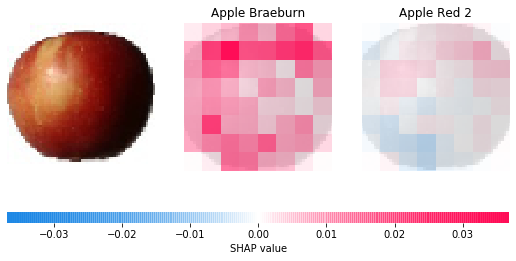

In [184]:
displot_shap(X, 0, model_1, layer, inv_class_map)

/Users/shun_lung_chang/python_projects/thesis_jacobs/venv/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


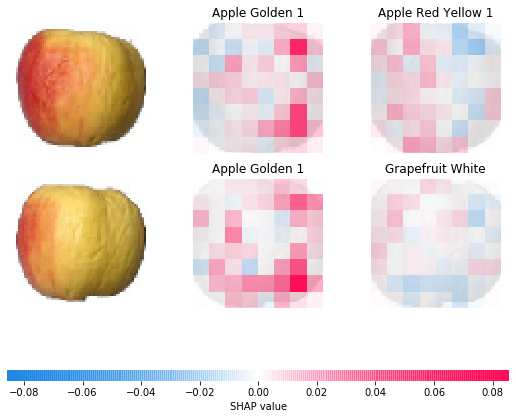

In [189]:
displot_shap(X, [1508, 1535], model_1, layer, inv_class_map)

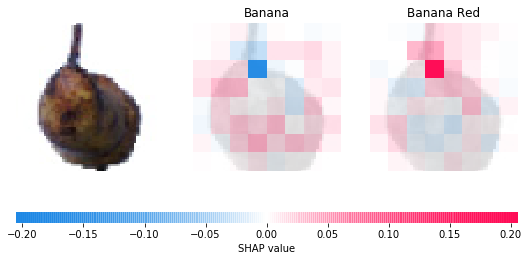

In [203]:
displot_shap(X, 11094, model_1, layer, inv_class_map)